# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

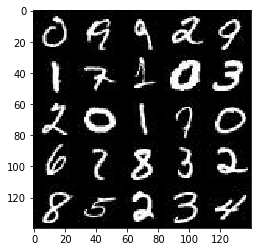

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

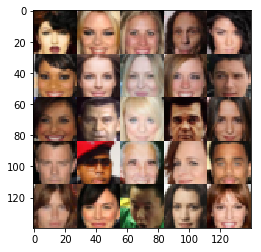

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, (None), name="learning_rate")
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
    
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)        

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # Run the generator
    g_model = generator(input_z, out_channel_dim)
    
    # Run the discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
# Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        #tf.reset_default_graph()

        self.input_real, self.input_z, self.learning_rate = model_inputs(*real_size, z_size)

        self.d_loss, self.g_loss = model_loss(self.input_real, 
                                              self.input_z, 
                                              real_size[2])
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    import time 
    
    # Instantiate model
    net = GAN(data_shape[1:], z_dim, learning_rate, beta1=beta1)
    

    with tf.Session() as sess:
        #tf.reset_default_graph()
        
        # Initialize variables
        print('initiating')
        sess.run(tf.global_variables_initializer())
        
        # Epochs, track loss and generate samples
        steps=0
        samples,losses = [],[]
        for epoch_i in range(epoch_count):
            
            t_e1=time.time()
            
            # Train on minibatches
            print('Epoch {} of {}'.format(epoch_i+1, epoch_count))
            for batch_images in get_batches(batch_size):
                
                t_s1 = time.time()
                
                
                # Batch data
                x = batch_images*2
                batch_z = np.random.uniform(-1,1, size=(x.shape[0], z_dim))
                
                # Optimize on batch
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, 
                                                   net.input_z: batch_z, 
                                                   net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_real: x, 
                                                   net.input_z: batch_z, 
                                                   net.learning_rate: learning_rate})
                
                
                # Get losses after step
                train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                #losses.append((train_loss_d, train_loss_g))
                
                
                
                if steps%50==0:
                    t_s2 = time.time()
                    print("{} steps took {} seconds".format(steps,t_s2-t_e1))
                if steps%150==0:
                    # Get samples every 100 steps
                    show_generator_output(sess, 
                                          n_images=25, 
                                          input_z=net.input_z,
                                          out_channel_dim=data_shape[3], 
                                          image_mode=data_image_mode)
                    print("\t\tDiscriminator loss: ", train_loss_d)
                    print("\t\tGenerator loss: ", train_loss_g)
                
                steps+=1
                
            
            t_e2=time.time()
            print("epoch took {} seconds".format(t_e2-t_e1))
            
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initiating
Epoch 1 of 2
0 steps took 1.4088053703308105 seconds


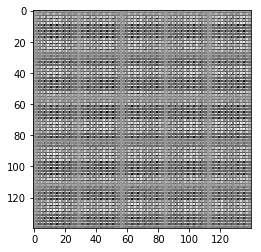

		Discriminator loss:  3.18511
		Generator loss:  0.0695956
50 steps took 15.231418132781982 seconds
100 steps took 28.415936708450317 seconds
150 steps took 41.60784196853638 seconds


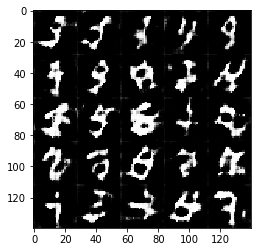

		Discriminator loss:  1.23091
		Generator loss:  0.929573
200 steps took 55.394540786743164 seconds
250 steps took 68.58658957481384 seconds
300 steps took 81.81910276412964 seconds


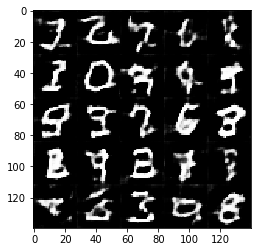

		Discriminator loss:  1.50182
		Generator loss:  0.560268
350 steps took 95.50016260147095 seconds
400 steps took 108.68236589431763 seconds
450 steps took 121.85046148300171 seconds


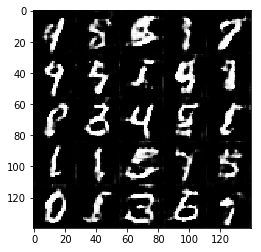

		Discriminator loss:  1.21711
		Generator loss:  1.60239
500 steps took 135.51630306243896 seconds
550 steps took 148.67601084709167 seconds
600 steps took 161.8415970802307 seconds


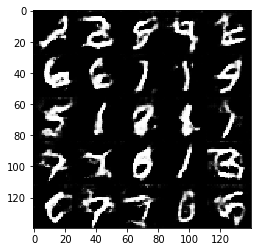

		Discriminator loss:  1.18712
		Generator loss:  0.71439
650 steps took 175.4856779575348 seconds
700 steps took 188.6477837562561 seconds
750 steps took 201.8001275062561 seconds


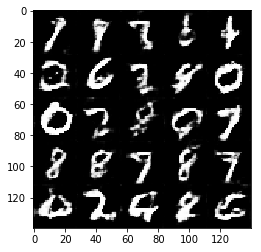

		Discriminator loss:  0.867083
		Generator loss:  1.0397
800 steps took 215.46549820899963 seconds
850 steps took 228.64992904663086 seconds
900 steps took 241.85489439964294 seconds


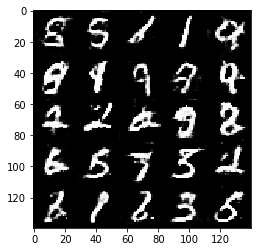

		Discriminator loss:  1.91187
		Generator loss:  0.295792
epoch took 251.83104515075684 seconds
Epoch 2 of 2
950 steps took 3.678842544555664 seconds
1000 steps took 16.834648847579956 seconds
1050 steps took 29.995959758758545 seconds


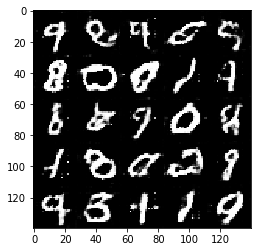

		Discriminator loss:  0.878375
		Generator loss:  1.48433
1100 steps took 43.71199440956116 seconds
1150 steps took 56.94518780708313 seconds
1200 steps took 70.121511220932 seconds


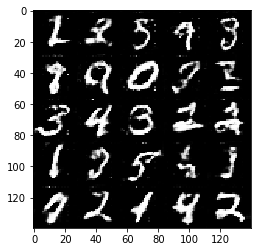

		Discriminator loss:  1.31741
		Generator loss:  0.621418
1250 steps took 83.89123916625977 seconds
1300 steps took 97.04331254959106 seconds
1350 steps took 110.21339797973633 seconds


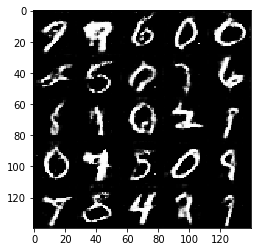

		Discriminator loss:  1.7449
		Generator loss:  1.22593
1400 steps took 123.89278769493103 seconds
1450 steps took 137.05649971961975 seconds
1500 steps took 150.2221930027008 seconds


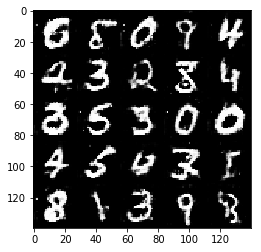

		Discriminator loss:  0.78076
		Generator loss:  1.87623
1550 steps took 163.88489699363708 seconds
1600 steps took 177.0857183933258 seconds
1650 steps took 190.24441957473755 seconds


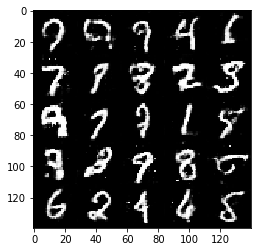

		Discriminator loss:  1.06396
		Generator loss:  0.716143
1700 steps took 203.9169991016388 seconds
1750 steps took 217.10128688812256 seconds
1800 steps took 230.2593286037445 seconds


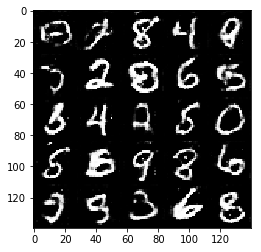

		Discriminator loss:  2.67286
		Generator loss:  0.14335
1850 steps took 243.94884157180786 seconds
epoch took 250.00984239578247 seconds


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initiating
Epoch 1 of 2
0 steps took 0.7739670276641846 seconds


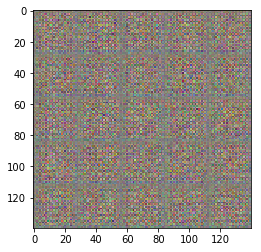

		Discriminator loss:  1.44761
		Generator loss:  0.465558
50 steps took 17.56232500076294 seconds
100 steps took 33.82834458351135 seconds
150 steps took 50.12925624847412 seconds


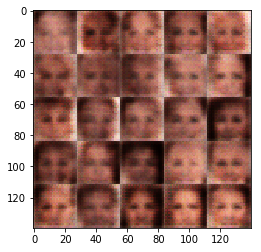

		Discriminator loss:  1.09976
		Generator loss:  1.02308
200 steps took 66.93318939208984 seconds
250 steps took 83.22797465324402 seconds
300 steps took 99.54113578796387 seconds


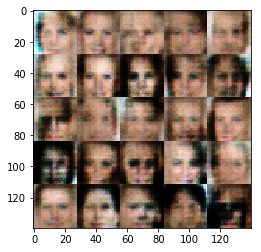

		Discriminator loss:  1.26381
		Generator loss:  0.925043
350 steps took 116.41757845878601 seconds
400 steps took 132.69027996063232 seconds
450 steps took 148.95645546913147 seconds


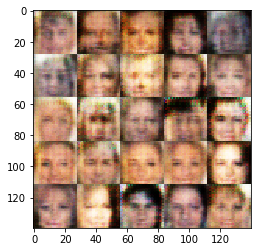

		Discriminator loss:  1.29636
		Generator loss:  0.827531
500 steps took 165.77271151542664 seconds
550 steps took 182.03365349769592 seconds
600 steps took 198.35871720314026 seconds


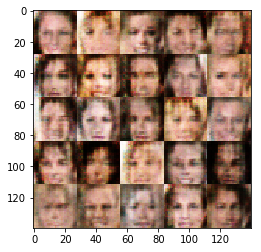

		Discriminator loss:  1.35575
		Generator loss:  0.754961
650 steps took 215.1627597808838 seconds
700 steps took 231.42720675468445 seconds
750 steps took 247.70521664619446 seconds


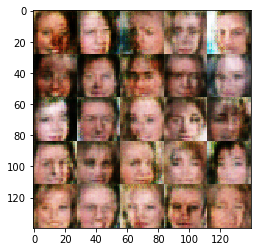

		Discriminator loss:  1.32906
		Generator loss:  1.30842
800 steps took 264.60347986221313 seconds
850 steps took 280.8819372653961 seconds
900 steps took 297.1576223373413 seconds


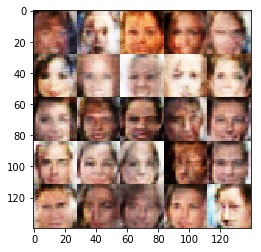

		Discriminator loss:  1.26786
		Generator loss:  0.739668
950 steps took 313.9817109107971 seconds
1000 steps took 330.2798972129822 seconds
1050 steps took 346.5846345424652 seconds


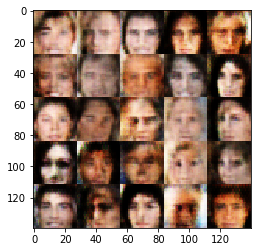

		Discriminator loss:  0.964047
		Generator loss:  1.05394
1100 steps took 363.38401055336 seconds
1150 steps took 379.6557939052582 seconds
1200 steps took 395.9355034828186 seconds


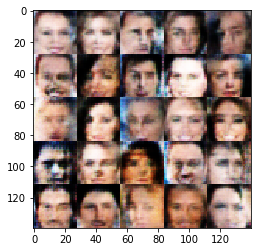

		Discriminator loss:  1.28867
		Generator loss:  1.56219
1250 steps took 412.81261444091797 seconds
1300 steps took 429.12765622138977 seconds
1350 steps took 445.4546926021576 seconds


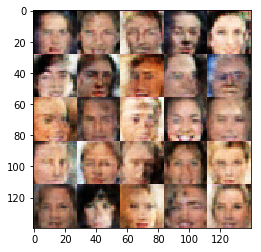

		Discriminator loss:  1.52835
		Generator loss:  0.397184
1400 steps took 462.28124380111694 seconds
1450 steps took 478.5491237640381 seconds
1500 steps took 494.85037326812744 seconds


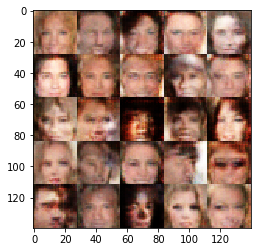

		Discriminator loss:  1.37062
		Generator loss:  0.544895
1550 steps took 511.6411280632019 seconds
1600 steps took 527.9225342273712 seconds
1650 steps took 544.1728200912476 seconds


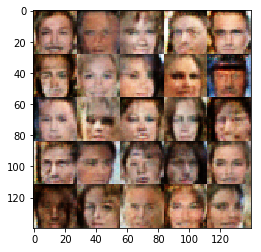

		Discriminator loss:  1.22598
		Generator loss:  0.718032
1700 steps took 560.9878857135773 seconds
1750 steps took 577.2617845535278 seconds
1800 steps took 593.5319945812225 seconds


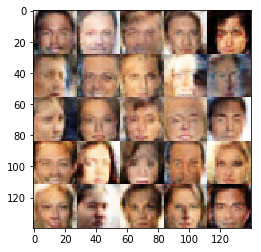

		Discriminator loss:  1.26295
		Generator loss:  0.914406
1850 steps took 610.3539855480194 seconds
1900 steps took 626.6488070487976 seconds
1950 steps took 642.9508800506592 seconds


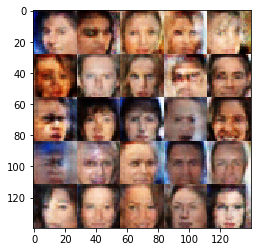

		Discriminator loss:  1.32474
		Generator loss:  0.559121
2000 steps took 659.897602558136 seconds
2050 steps took 676.1607484817505 seconds
2100 steps took 692.4161624908447 seconds


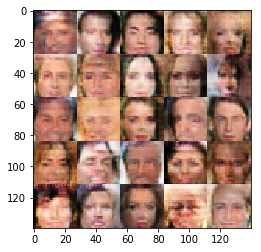

		Discriminator loss:  1.33707
		Generator loss:  0.665741
2150 steps took 709.259309053421 seconds
2200 steps took 725.6163167953491 seconds
2250 steps took 741.8940825462341 seconds


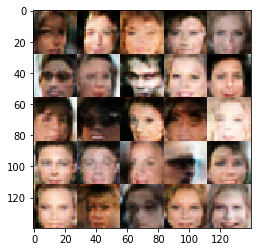

		Discriminator loss:  1.11287
		Generator loss:  1.02489
2300 steps took 758.7686622142792 seconds
2350 steps took 775.0788242816925 seconds
2400 steps took 791.3780908584595 seconds


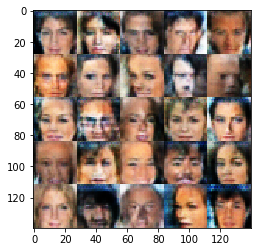

		Discriminator loss:  1.33679
		Generator loss:  0.572302
2450 steps took 809.0426158905029 seconds
2500 steps took 827.4110395908356 seconds
2550 steps took 845.8710298538208 seconds


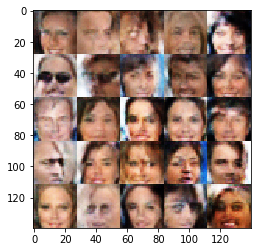

		Discriminator loss:  1.43452
		Generator loss:  0.467624
2600 steps took 864.9785757064819 seconds
2650 steps took 883.4661979675293 seconds
2700 steps took 902.0072050094604 seconds


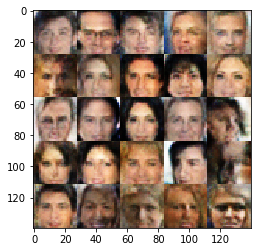

		Discriminator loss:  1.38278
		Generator loss:  0.719108
2750 steps took 921.215354681015 seconds
2800 steps took 940.3034064769745 seconds
2850 steps took 959.3636827468872 seconds


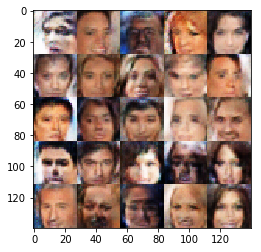

		Discriminator loss:  1.38991
		Generator loss:  0.553152
2900 steps took 978.4523746967316 seconds
2950 steps took 996.9269454479218 seconds
3000 steps took 1015.4518325328827 seconds


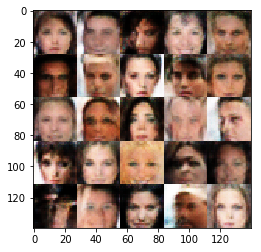

		Discriminator loss:  1.59672
		Generator loss:  0.381776
3050 steps took 1034.5406002998352 seconds
3100 steps took 1053.004031419754 seconds
3150 steps took 1071.520395040512 seconds


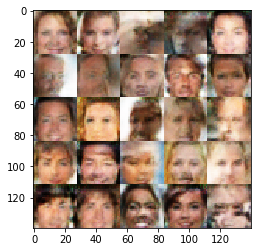

		Discriminator loss:  1.32224
		Generator loss:  0.7966
epoch took 1077.2958788871765 seconds
Epoch 2 of 2
3200 steps took 11.753869771957397 seconds
3250 steps took 28.058977365493774 seconds
3300 steps took 44.35752987861633 seconds


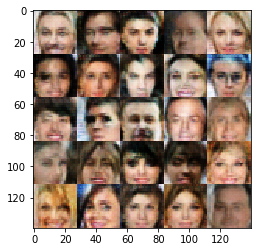

		Discriminator loss:  1.21858
		Generator loss:  0.635646
3350 steps took 61.243130683898926 seconds
3400 steps took 77.55668759346008 seconds
3450 steps took 93.84437823295593 seconds


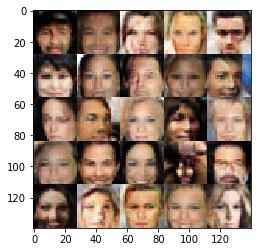

		Discriminator loss:  1.29469
		Generator loss:  0.644869
3500 steps took 110.87734293937683 seconds
3550 steps took 127.14096999168396 seconds
3600 steps took 143.406982421875 seconds


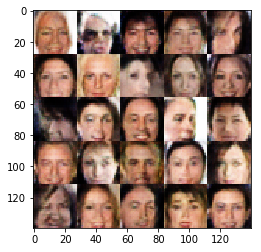

		Discriminator loss:  1.35164
		Generator loss:  0.521567
3650 steps took 160.2804193496704 seconds
3700 steps took 176.5342152118683 seconds
3750 steps took 192.8254270553589 seconds


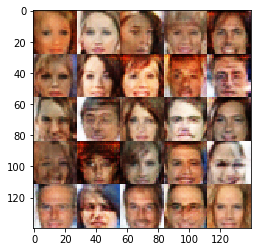

		Discriminator loss:  1.20291
		Generator loss:  0.736014
3800 steps took 209.64657020568848 seconds
3850 steps took 225.8932328224182 seconds
3900 steps took 242.15300345420837 seconds


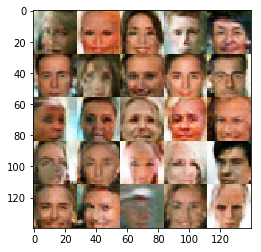

		Discriminator loss:  1.12852
		Generator loss:  0.782219
3950 steps took 259.04568457603455 seconds
4000 steps took 275.3981623649597 seconds
4050 steps took 291.7140235900879 seconds


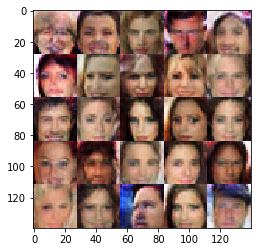

		Discriminator loss:  1.56719
		Generator loss:  0.414914
4100 steps took 308.55603861808777 seconds
4150 steps took 324.80790305137634 seconds
4200 steps took 341.0580005645752 seconds


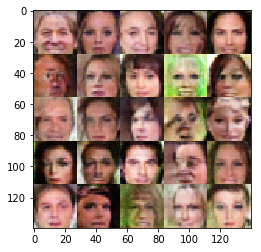

		Discriminator loss:  1.2476
		Generator loss:  0.66591
4250 steps took 357.9757750034332 seconds
4300 steps took 374.2504141330719 seconds
4350 steps took 390.52289056777954 seconds


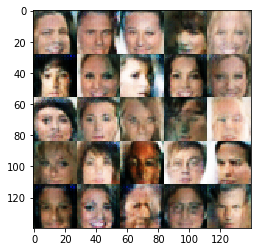

		Discriminator loss:  1.04848
		Generator loss:  0.977101
4400 steps took 407.4446015357971 seconds
4450 steps took 423.71645879745483 seconds
4500 steps took 439.96890473365784 seconds


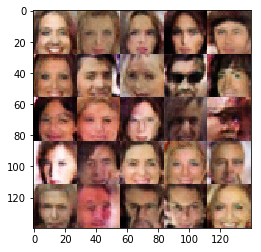

		Discriminator loss:  1.39806
		Generator loss:  0.699681
4550 steps took 456.8644337654114 seconds
4600 steps took 473.15494537353516 seconds
4650 steps took 489.4425222873688 seconds


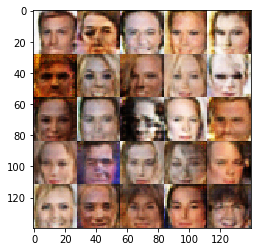

		Discriminator loss:  1.81359
		Generator loss:  0.30284
4700 steps took 506.354798078537 seconds
4750 steps took 522.6191020011902 seconds
4800 steps took 538.8680393695831 seconds


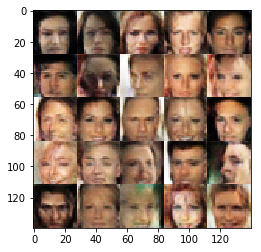

		Discriminator loss:  1.119
		Generator loss:  0.715238
4850 steps took 555.7623689174652 seconds
4900 steps took 572.0462808609009 seconds
4950 steps took 588.4063794612885 seconds


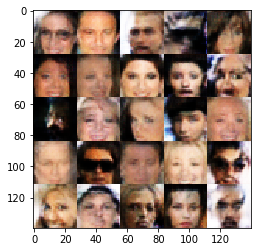

		Discriminator loss:  1.18909
		Generator loss:  0.755266
5000 steps took 605.485315322876 seconds
5050 steps took 621.778656244278 seconds
5100 steps took 638.0494287014008 seconds


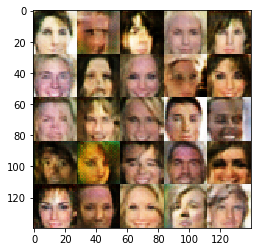

		Discriminator loss:  1.02004
		Generator loss:  1.12728
5150 steps took 654.9198076725006 seconds
5200 steps took 671.1656806468964 seconds
5250 steps took 687.4290683269501 seconds


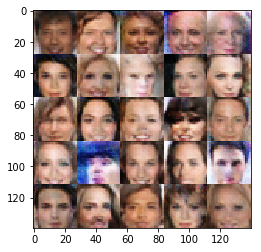

		Discriminator loss:  1.03078
		Generator loss:  0.950746
5300 steps took 704.3416695594788 seconds
5350 steps took 720.6060338020325 seconds
5400 steps took 736.9017252922058 seconds


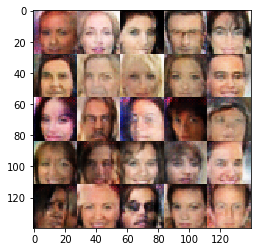

		Discriminator loss:  1.29991
		Generator loss:  0.601908
5450 steps took 753.7813732624054 seconds
5500 steps took 770.0452272891998 seconds
5550 steps took 786.285224199295 seconds


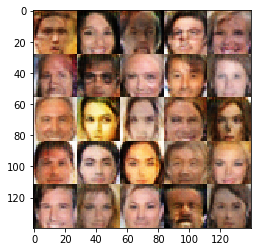

		Discriminator loss:  1.33973
		Generator loss:  0.621262
5600 steps took 803.1909260749817 seconds
5650 steps took 819.452662229538 seconds
5700 steps took 835.715987443924 seconds


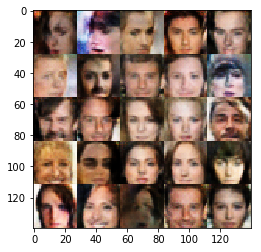

		Discriminator loss:  1.31778
		Generator loss:  0.541032
5750 steps took 852.6855745315552 seconds
5800 steps took 868.9470512866974 seconds
5850 steps took 885.2796955108643 seconds


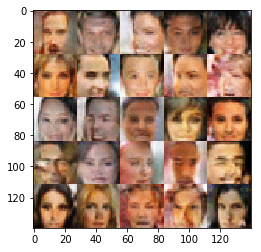

		Discriminator loss:  1.27436
		Generator loss:  0.906472
5900 steps took 902.2023553848267 seconds
5950 steps took 918.4514937400818 seconds
6000 steps took 934.7178273200989 seconds


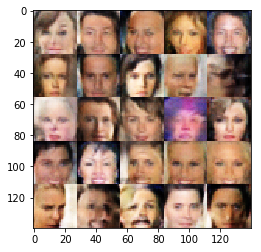

		Discriminator loss:  1.12467
		Generator loss:  0.935666
6050 steps took 951.6799373626709 seconds
6100 steps took 967.9696977138519 seconds
6150 steps took 984.2742516994476 seconds


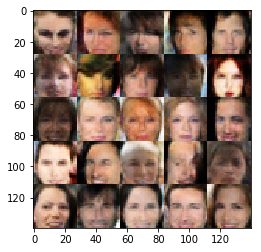

		Discriminator loss:  1.11447
		Generator loss:  0.771702
6200 steps took 1001.2240653038025 seconds
6250 steps took 1017.489725112915 seconds
6300 steps took 1033.7531096935272 seconds


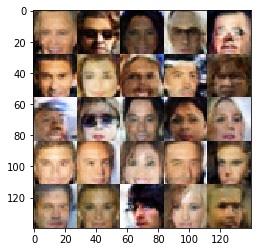

		Discriminator loss:  1.7585
		Generator loss:  0.372073
epoch took 1043.85294175148 seconds


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.